# Case Study 2

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model, 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering, 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering, 
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing 
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [ ]:
#!pip install h5py==2.10.0 --use-pep517
#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install scikit-network
#!pip install pickle-mixin==1.0.2
#!pip install matplotlib
#!pip install plotly

### Prepare Tissue Representations

In [12]:
import h5py
import numpy as np
import pickle

In [13]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [14]:
vgg16_content

<HDF5 file "vgg16_dim_reduced_feature.h5" (mode r)>

In [15]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [16]:
vgg16_pca_feature

array([[ -90.864815 ,  107.03243  ,  116.16385  , ...,    8.259951 ,
          -1.1383446,   -9.175951 ],
       [ -74.06226  ,  117.31615  ,   95.24547  , ...,   -1.9739974,
           6.8172655,    4.2547903],
       [ -81.875336 ,  122.84872  ,   83.767784 , ...,   -1.3287221,
          13.65623  ,  -11.109545 ],
       ...,
       [  32.70835  ,   31.183935 ,  -47.30978  , ...,    4.2004256,
           3.599823 ,    6.0058775],
       [ -39.911785 , -105.81029  ,  122.37118  , ...,  -14.908715 ,
          -1.1814455,  -10.837135 ],
       [  32.35425  ,  -50.3373   ,   66.50197  , ...,   -3.859397 ,
          -1.047523 ,    2.3827858]], dtype=float32)

In [17]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [18]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
filename = np.array([str(x) for x in filename])
labels = np.array([x.split('/')[2] for x in filename])
labels

array(['ADI', 'ADI', 'ADI', ..., 'TUM', 'TUM', 'TUM'], dtype='<U4')

In [19]:
#import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

paths = {
    'PathologyGAN': 'colon_nct_feature/pge_dim_reduced_feature.h5',
    'ResNet50': 'colon_nct_feature/resnet50_dim_reduced_feature.h5',
    'InceptionV3': 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5',
    'VGG16': 'colon_nct_feature/vgg16_dim_reduced_feature.h5'
}

feature_sets = {}
labels_ground_truth = None

with h5py.File(paths['PathologyGAN'], mode='r') as f:
    filename = np.squeeze(f['file_name'])
    filename = np.array([str(x) for x in filename])
    labels_ground_truth = np.array([x.split('/')[2] for x in filename])

for model_name, path in paths.items():
    with h5py.File(path, mode='r') as f:
        X = f['pca_feature'][...]
        feature_sets[model_name] = StandardScaler().fit_transform(X)

print(f"loaded {len(feature_sets)} datasets")
print(f"size of data: {len(labels_ground_truth)}")
print(f"The number of Ground Truth categories: {len(np.unique(labels_ground_truth))} ({np.unique(labels_ground_truth)})")

loaded 4 datasets
size of data: 5000
The number of Ground Truth categories: 9 (['ADI' 'BACK' 'DEB' 'LYM' 'MUC' 'MUS' 'NORM' 'STR' 'TUM'])


In [20]:
#PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sknetwork.clustering import Louvain
from sklearn.metrics import silhouette_score, v_measure_score

k_range = [2, 5, 9, 12, 15] 
results = []

def run_clustering_experiment(dataset_name, X, y_true):
    print(f"processing datasets: {dataset_name}...")
    
    # --- 1. K-Means ---
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(X)
        results.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'KMeans',
            'Param (k)': k,
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 2. Gaussian Mixture Model (GMM) ---
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels_pred = gmm.fit_predict(X)
        results.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'GMM',
            'Param (k)': k,
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 3. Hierarchical Clustering  ---
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels_pred = agg.fit_predict(X)
        results.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'Hierarchical',
            'Param (k)': k,
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 4. Louvain Clustering ---
    adjacency = kneighbors_graph(X, n_neighbors=30, mode='connectivity', include_self=False)
    
    resolutions = [0.5, 0.8, 1.0, 1.2, 1.5]
    for res in resolutions:
        louvain = Louvain(resolution=res, random_state=42)
        labels_pred = louvain.fit_transform(adjacency)
        
        n_clusters_found = len(np.unique(labels_pred))
        
        if n_clusters_found > 1:
            results.append({
                'Feature_Set': dataset_name,
                'Algorithm': 'Louvain',
                'Param (k)': f"res={res} (k={n_clusters_found})",
                'Silhouette': silhouette_score(X, labels_pred),
                'V-Measure': v_measure_score(y_true, labels_pred)
            })

for name, data in feature_sets.items():
    run_clustering_experiment(name, data, labels_ground_truth)

df_results = pd.DataFrame(results)

print("\nPerformance (sorted by V-Measure):")
display(df_results.sort_values(by='V-Measure', ascending=False))

processing datasets: PathologyGAN...
processing datasets: ResNet50...
processing datasets: InceptionV3...
processing datasets: VGG16...

Performance (sorted by V-Measure):


,Feature_Set,Algorithm,Param (k),Silhouette,V-Measure
51,VGG16,GMM,5,-0.068229,0.607175
22,ResNet50,GMM,9,-0.066852,0.595012
23,ResNet50,GMM,12,-0.060316,0.587961
54,VGG16,GMM,15,-0.055393,0.581490
58,VGG16,Hierarchical,12,-0.069846,0.575968
57,VGG16,Hierarchical,9,-0.068467,0.575961
29,ResNet50,Hierarchical,15,-0.070078,0.568980
59,VGG16,Hierarchical,15,-0.063245,0.562553
28,ResNet50,Hierarchical,12,-0.079668,0.559380
24,ResNet50,GMM,15,-0.032287,0.558667


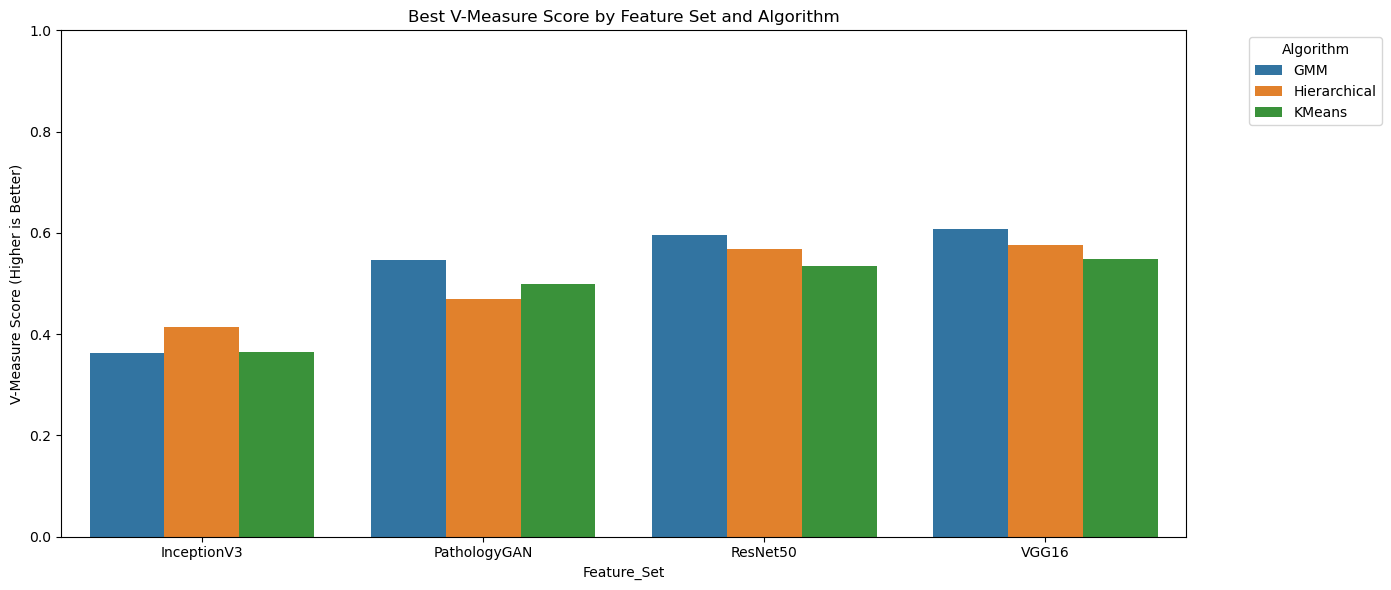

Visualizing composition for best model: GMM on VGG16 with 5


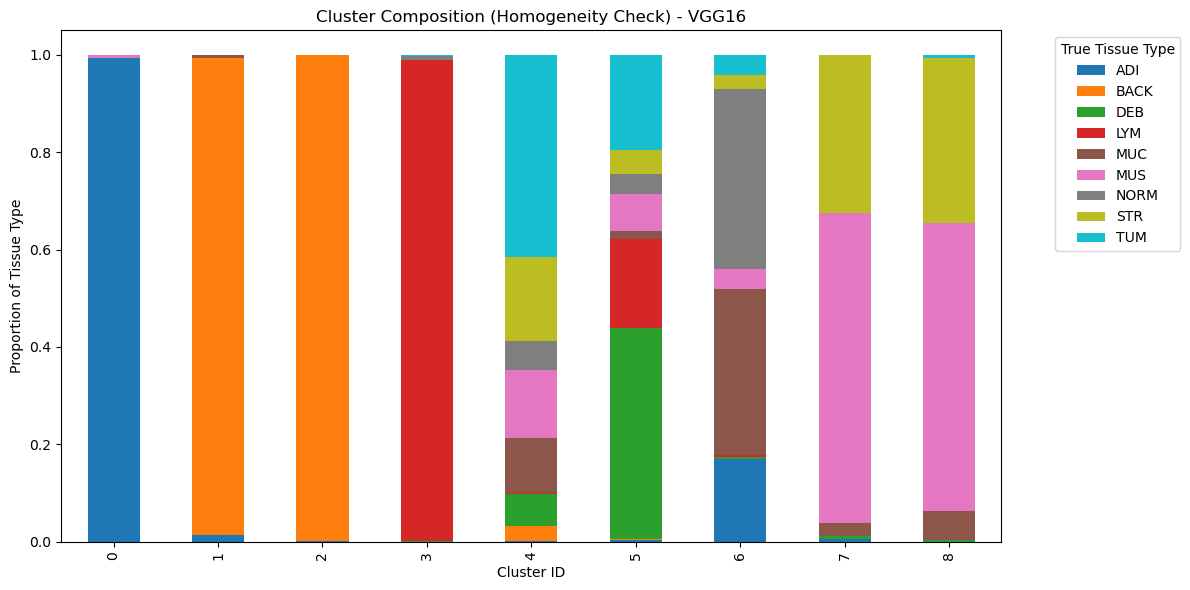

In [21]:
#PCA
plt.figure(figsize=(14, 6))

best_results = df_results.loc[df_results.groupby(['Feature_Set', 'Algorithm'])['V-Measure'].idxmax()]

sns.barplot(data=best_results, x='Feature_Set', y='V-Measure', hue='Algorithm')
plt.title('Best V-Measure Score by Feature Set and Algorithm')
plt.ylabel('V-Measure Score (Higher is Better)')
plt.ylim(0, 1)
plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

best_row = df_results.sort_values(by='V-Measure', ascending=False).iloc[0]
best_feature = best_row['Feature_Set']
best_algo = best_row['Algorithm']
best_k = best_row['Param (k)']

print(f"Visualizing composition for best model: {best_algo} on {best_feature} with {best_k}")

X_best = feature_sets[best_feature]

model = KMeans(n_clusters=9, random_state=42, n_init=10)
labels_best = model.fit_predict(X_best)


cluster_df = pd.DataFrame({'Cluster': labels_best, 'True_Label': labels_ground_truth})

crosstab = pd.crosstab(cluster_df['Cluster'], cluster_df['True_Label'], normalize='index')

crosstab.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title(f'Cluster Composition (Homogeneity Check) - {best_feature}')
plt.xlabel('Cluster ID')
plt.ylabel('Proportion of Tissue Type')
plt.legend(title='True Tissue Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Loaded the UMAP feature set. Sample size: 5000
Processing the UMAP feature set： PathologyGAN...
Processing the UMAP feature set： ResNet50...
Processing the UMAP feature set： InceptionV3...
Processing the UMAP feature set： VGG16...

Performance with UMAP features (sorted by V-Measure):


,Feature_Set,Algorithm,Param,Silhouette,V-Measure
28,ResNet50,Hierarchical,k=12,0.421433,0.704331
17,ResNet50,KMeans,k=9,0.375515,0.692935
29,ResNet50,Hierarchical,k=15,0.429916,0.679341
18,ResNet50,KMeans,k=12,0.404369,0.676685
24,ResNet50,GMM,k=15,0.422647,0.672648
19,ResNet50,KMeans,k=15,0.433208,0.671646
54,VGG16,GMM,k=15,0.314713,0.668577
53,VGG16,GMM,k=12,0.331446,0.663314
48,VGG16,KMeans,k=12,0.407090,0.663222
59,VGG16,Hierarchical,k=15,0.375215,0.651186


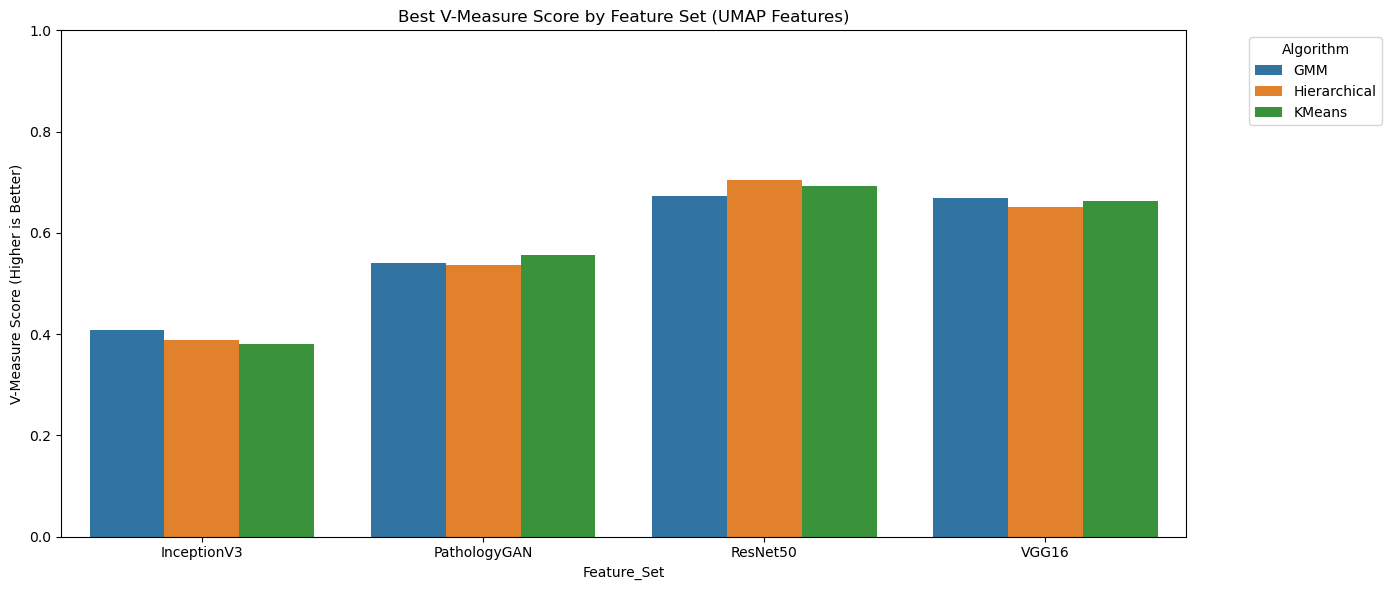

In [22]:
#UMAP
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score, v_measure_score
from sknetwork.clustering import Louvain

paths = {
    'PathologyGAN': 'colon_nct_feature/pge_dim_reduced_feature.h5',
    'ResNet50': 'colon_nct_feature/resnet50_dim_reduced_feature.h5',
    'InceptionV3': 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5',
    'VGG16': 'colon_nct_feature/vgg16_dim_reduced_feature.h5'
}

feature_sets_umap = {}
labels_ground_truth = None

with h5py.File(paths['PathologyGAN'], mode='r') as f:
    filename = np.squeeze(f['file_name'])
    filename = np.array([str(x) for x in filename])
    labels_ground_truth = np.array([x.split('/')[2] for x in filename])

for model_name, path in paths.items():
    with h5py.File(path, mode='r') as f:
        X = f['umap_feature'][...]
        feature_sets_umap[model_name] = StandardScaler().fit_transform(X)

print(f"Loaded the UMAP feature set. Sample size: {len(labels_ground_truth)}")

k_range = [2, 5, 9, 12, 15] 
results_umap = []

def run_clustering_experiment_umap(dataset_name, X, y_true):
    print(f"Processing the UMAP feature set： {dataset_name}...")
    
    # --- 1. K-Means ---
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_pred = kmeans.fit_predict(X)
        results_umap.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'KMeans',
            'Param': f"k={k}",
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 2. Gaussian Mixture Model (GMM) ---
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels_pred = gmm.fit_predict(X)
        results_umap.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'GMM',
            'Param': f"k={k}",
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 3. Hierarchical Clustering ---
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels_pred = agg.fit_predict(X)
        results_umap.append({
            'Feature_Set': dataset_name,
            'Algorithm': 'Hierarchical',
            'Param': f"k={k}",
            'Silhouette': silhouette_score(X, labels_pred),
            'V-Measure': v_measure_score(y_true, labels_pred)
        })

    # --- 4. Louvain Clustering ---
    if Louvain is not None:
        adjacency = kneighbors_graph(X, n_neighbors=30, mode='connectivity', include_self=False)
        
        resolutions = [0.5, 0.8, 1.0, 1.2, 1.5, 2.0]
        for res in resolutions:
            louvain = Louvain(resolution=res, random_state=42)
            labels_pred = louvain.fit_transform(adjacency)
            
            n_clusters_found = len(np.unique(labels_pred))
            
            if 1 < n_clusters_found < len(X):
                results_umap.append({
                    'Feature_Set': dataset_name,
                    'Algorithm': 'Louvain',
                    'Param': f"res={res} (k={n_clusters_found})",
                    'Silhouette': silhouette_score(X, labels_pred),
                    'V-Measure': v_measure_score(y_true, labels_pred)
                })

for name, data in feature_sets_umap.items():
    run_clustering_experiment_umap(name, data, labels_ground_truth)

df_results_umap = pd.DataFrame(results_umap)
print("\nPerformance with UMAP features (sorted by V-Measure):")
display(df_results_umap.sort_values(by='V-Measure', ascending=False))

if not df_results_umap.empty:
    plt.figure(figsize=(14, 6))
    best_results_umap = df_results_umap.loc[df_results_umap.groupby(['Feature_Set', 'Algorithm'])['V-Measure'].idxmax()]
    
    sns.barplot(data=best_results_umap, x='Feature_Set', y='V-Measure', hue='Algorithm')
    plt.title('Best V-Measure Score by Feature Set (UMAP Features)')
    plt.ylabel('V-Measure Score (Higher is Better)')
    plt.ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Algorithm')
    plt.tight_layout()
    plt.show()

Data loaded. Sample size: 5000

===Clustering Results (Sorted by V-Measure) ===


,Reduction,Feature,Algorithm,Param,Silhouette,V-Measure
15,UMAP,ResNet50,KMeans,9,0.375515,0.692935
17,UMAP,ResNet50,Hierarchical,9,0.381887,0.650523
22,UMAP,VGG16,GMM,9,0.319164,0.641815
21,UMAP,VGG16,KMeans,9,0.363421,0.603216
4,PCA,ResNet50,GMM,9,-0.066852,0.595012
16,UMAP,ResNet50,GMM,9,0.314884,0.592515
11,PCA,VGG16,Hierarchical,9,-0.068467,0.575961
23,UMAP,VGG16,Hierarchical,9,0.369039,0.575274
12,UMAP,PathologyGAN,KMeans,9,0.427342,0.552778
5,PCA,ResNet50,Hierarchical,9,-0.032076,0.550597


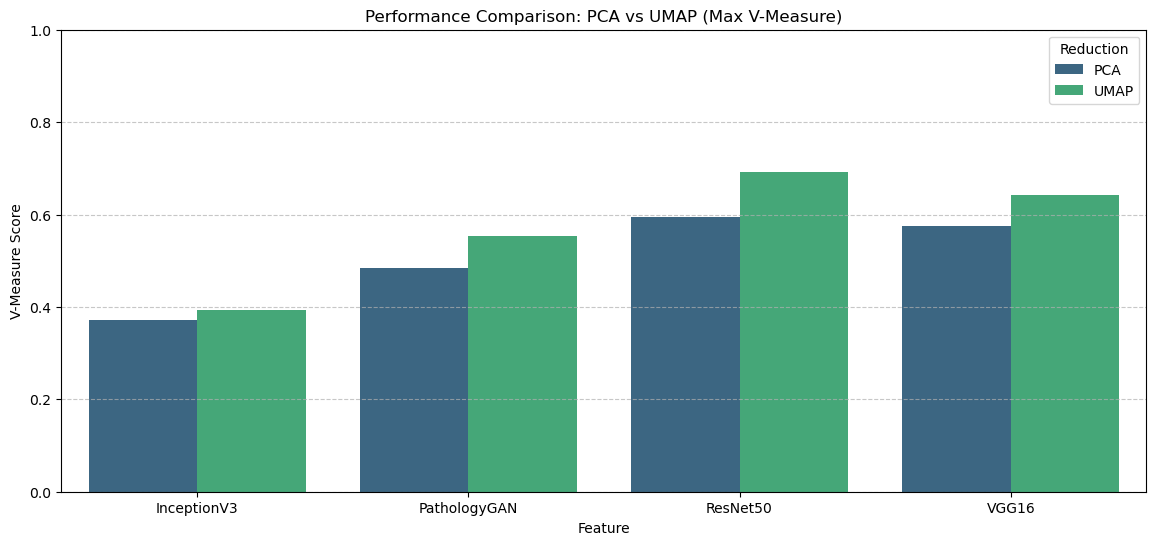

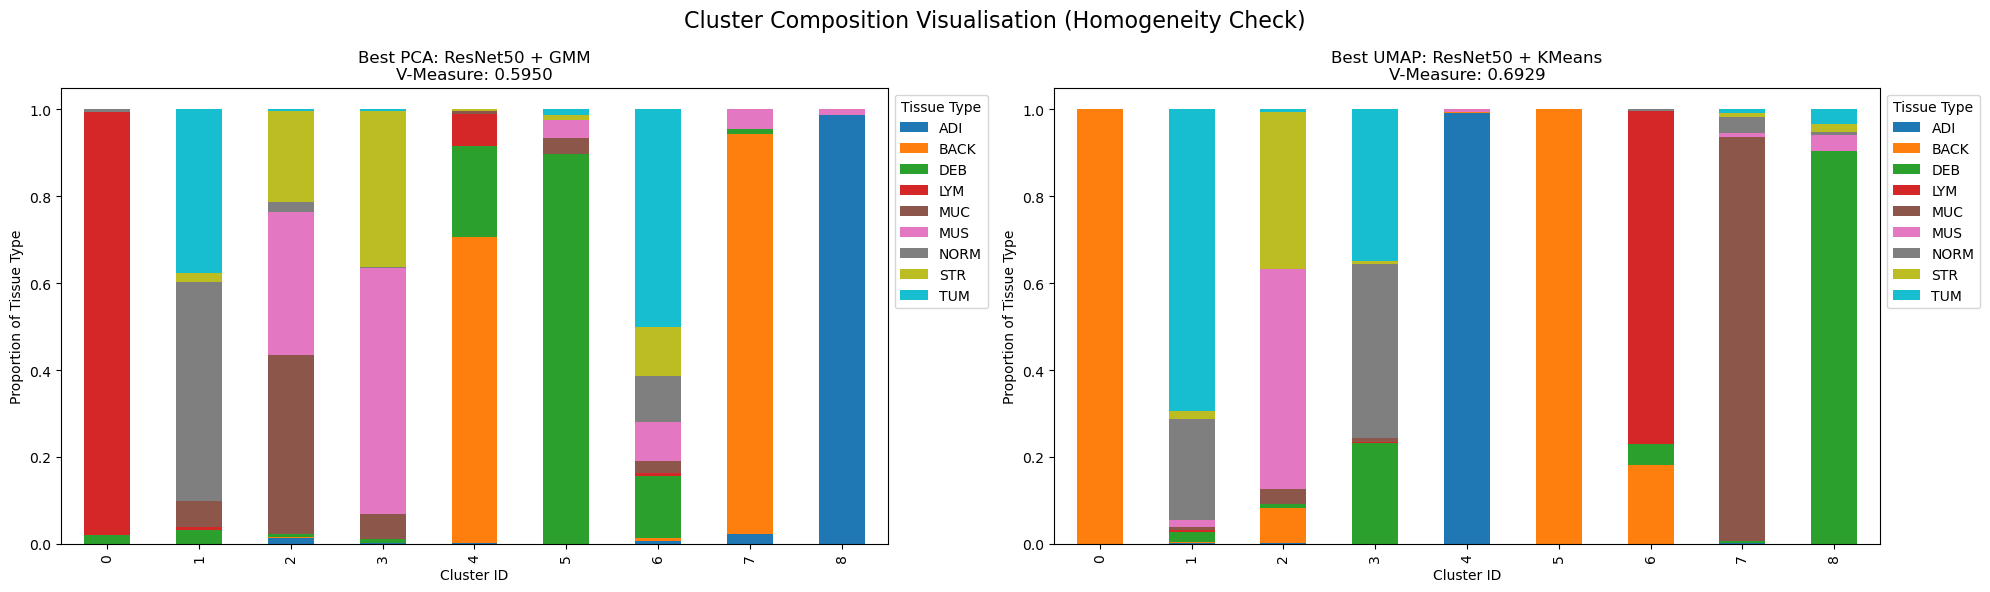

Generating all 3D scatter plots...


/var/folders/3r/4ffbwd0j4dv94ybqf3_9fbxw0000gn/T/ipykernel_24207/2359686476.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(np.unique(y_true)))


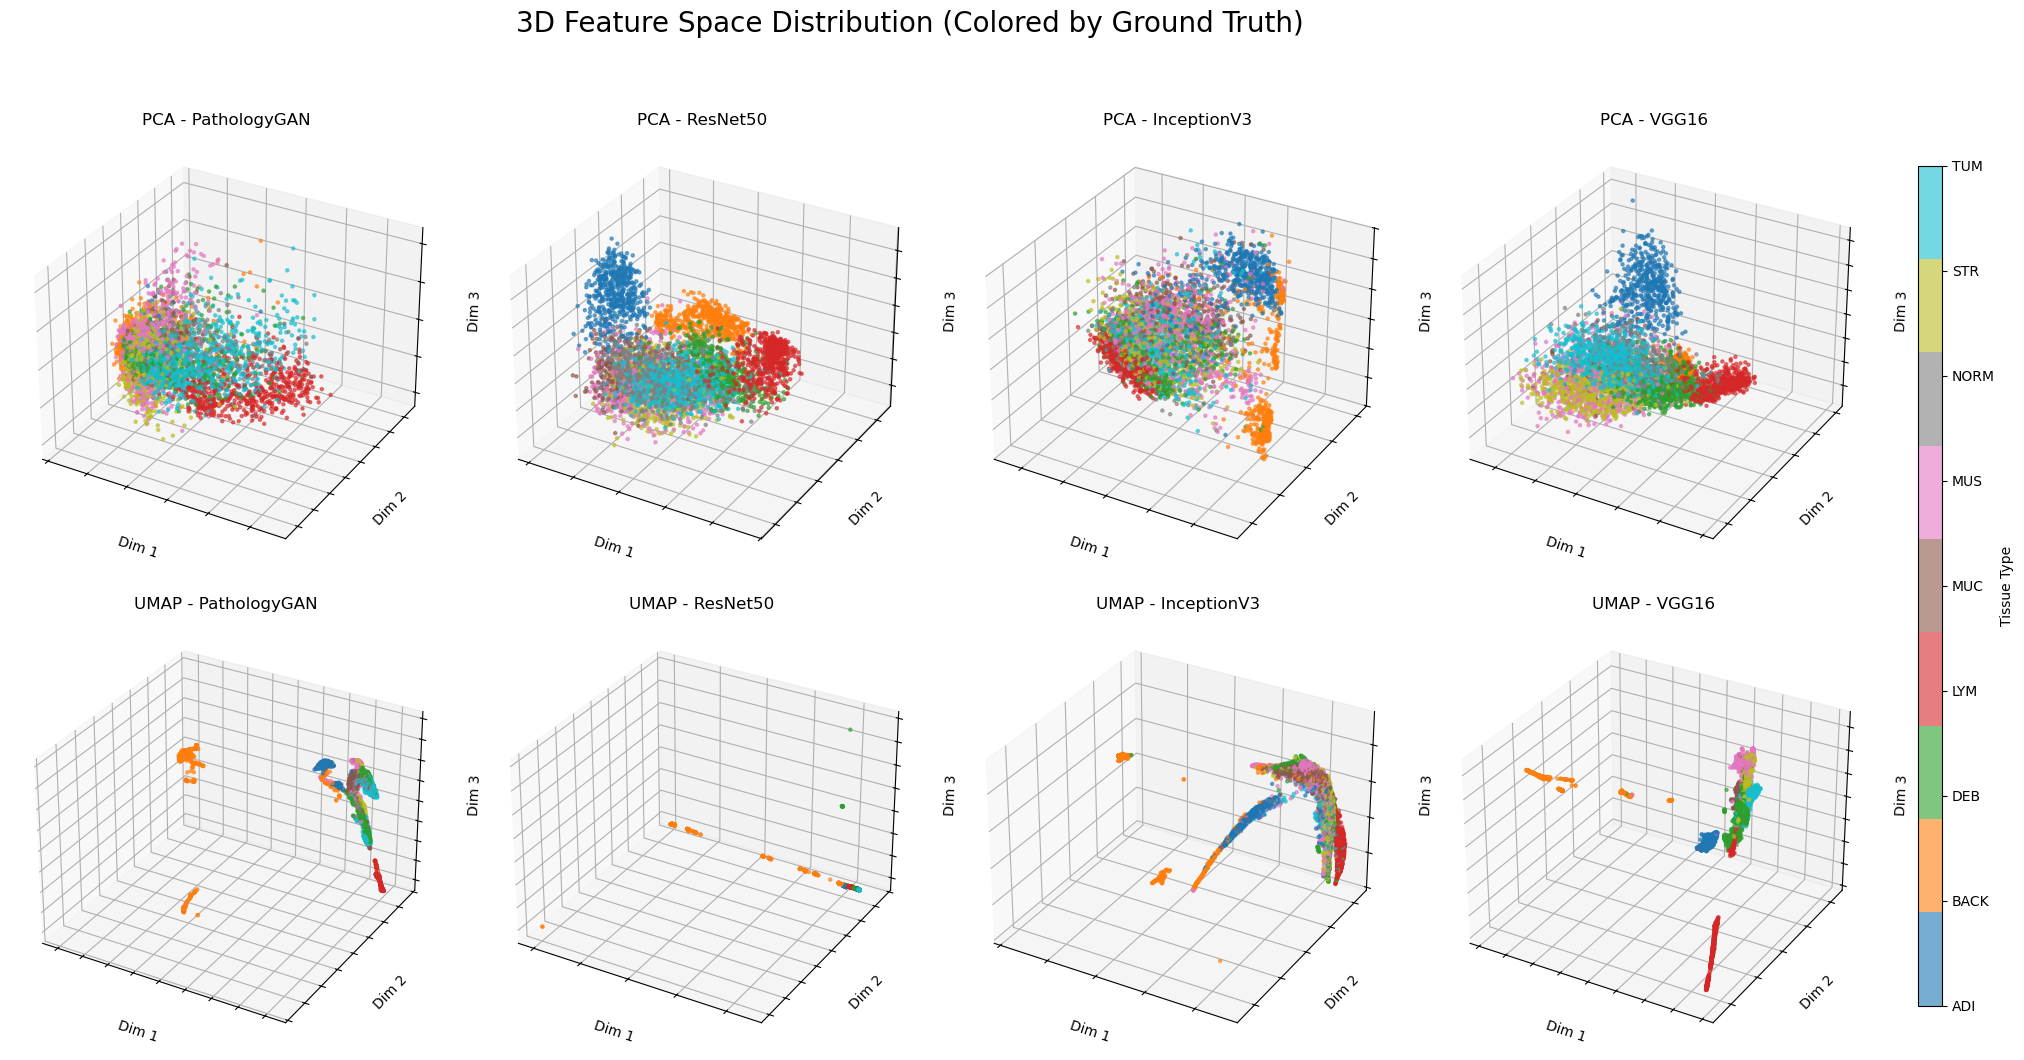

In [26]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score, v_measure_score

try:
    from sknetwork.clustering import Louvain
except ImportError:
    print("Didn't found 'sknetwork', Louvain will be skipped")
    Louvain = None

paths = {
    'PathologyGAN': 'colon_nct_feature/pge_dim_reduced_feature.h5',
    'ResNet50': 'colon_nct_feature/resnet50_dim_reduced_feature.h5',
    'InceptionV3': 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5',
    'VGG16': 'colon_nct_feature/vgg16_dim_reduced_feature.h5'
}

def load_data():
    data_store = {'PCA': {}, 'UMAP': {}}
    labels_ground_truth = None

    with h5py.File(paths['PathologyGAN'], mode='r') as f:
        filename = np.squeeze(f['file_name'])
        filename = np.array([str(x) for x in filename])
        labels_ground_truth = np.array([x.split('/')[2] for x in filename])

    for model_name, path in paths.items():
        with h5py.File(path, mode='r') as f:
            X_pca = f['pca_feature'][...]
            data_store['PCA'][model_name] = StandardScaler().fit_transform(X_pca)
            
            X_umap = f['umap_feature'][...]
            data_store['UMAP'][model_name] = StandardScaler().fit_transform(X_umap)
            
    return data_store, labels_ground_truth

datasets, y_true = load_data()
print(f"Data loaded. Sample size: {len(y_true)}")


results = []
k_range = [9]

def run_clustering(reduction_method, dataset_name, X, y_true):
    
    # --- 1. K-Means ---
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        results.append({
            'Reduction': reduction_method, 'Feature': dataset_name, 'Algorithm': 'KMeans',
            'Param': k, 'Silhouette': silhouette_score(X, labels), 'V-Measure': v_measure_score(y_true, labels),
            'Labels': labels
        })

    # --- 2. GMM ---
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X)
        results.append({
            'Reduction': reduction_method, 'Feature': dataset_name, 'Algorithm': 'GMM',
            'Param': k, 'Silhouette': silhouette_score(X, labels), 'V-Measure': v_measure_score(y_true, labels),
            'Labels': labels
        })

    # --- 3. Hierarchical ---
    for k in k_range:
        agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
        labels = agg.fit_predict(X)
        results.append({
            'Reduction': reduction_method, 'Feature': dataset_name, 'Algorithm': 'Hierarchical',
            'Param': k, 'Silhouette': silhouette_score(X, labels), 'V-Measure': v_measure_score(y_true, labels),
            'Labels': labels
        })

    # --- 4. Louvain ---
    if Louvain is not None:
        adjacency = kneighbors_graph(X, n_neighbors=30, mode='connectivity', include_self=False)
        for res in [0.8, 1.0, 1.2]: 
            louvain = Louvain(resolution=res, random_state=42)
            labels = louvain.fit_transform(adjacency)
            n_clusters = len(np.unique(labels))
            if 1 < n_clusters < 30: 
                results.append({
                    'Reduction': reduction_method, 'Feature': dataset_name, 'Algorithm': 'Louvain',
                    'Param': f"res={res}(k={n_clusters})", 'Silhouette': silhouette_score(X, labels), 
                    'V-Measure': v_measure_score(y_true, labels),
                    'Labels': labels
                })

for method in ['PCA', 'UMAP']:
    for name, data in datasets[method].items():
        run_clustering(method, name, data, y_true)

df_results = pd.DataFrame(results)

print("\n===Clustering Results (Sorted by V-Measure) ===")
display_cols = ['Reduction', 'Feature', 'Algorithm', 'Param', 'Silhouette', 'V-Measure']
display(df_results[display_cols].sort_values(by='V-Measure', ascending=False))

plt.figure(figsize=(14, 6))
best_scores = df_results.groupby(['Reduction', 'Feature'])['V-Measure'].max().reset_index()
sns.barplot(data=best_scores, x='Feature', y='V-Measure', hue='Reduction', palette='viridis')
plt.title('Performance Comparison: PCA vs UMAP (Max V-Measure)')
plt.ylabel('V-Measure Score')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

best_pca_idx = df_results[df_results['Reduction']=='PCA']['V-Measure'].idxmax()
best_umap_idx = df_results[df_results['Reduction']=='UMAP']['V-Measure'].idxmax()

rows_to_plot = [df_results.loc[best_pca_idx], df_results.loc[best_umap_idx]]

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, row in enumerate(rows_to_plot):
    method = row['Reduction']
    feature = row['Feature']
    algo = row['Algorithm']
    score = row['V-Measure']
    labels_pred = row['Labels']
    
    cluster_df = pd.DataFrame({'Cluster': labels_pred, 'True_Label': y_true})
    crosstab = pd.crosstab(cluster_df['Cluster'], cluster_df['True_Label'], normalize='index')
    
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], colormap='tab10')
    axes[i].set_title(f'Best {method}: {feature} + {algo}\nV-Measure: {score:.4f}')
    axes[i].set_xlabel('Cluster ID')
    axes[i].set_ylabel('Proportion of Tissue Type')
    axes[i].legend(title='Tissue Type', bbox_to_anchor=(1.0, 1.0))

plt.suptitle('Cluster Composition Visualisation (Homogeneity Check)', fontsize=16)
plt.tight_layout()
plt.show()

unique_labels = np.unique(y_true)
label_to_id = {label: i for i, label in enumerate(unique_labels)}
y_true_id = np.array([label_to_id[label] for label in y_true])
print("Generating all 3D scatter plots...")

fig = plt.figure(figsize=(24, 12))
feature_names = list(paths.keys()) 

cmap = plt.cm.get_cmap('tab10', len(np.unique(y_true)))

plot_idx = 1
for method in ['PCA', 'UMAP']:
    for feat_name in feature_names:
        ax = fig.add_subplot(2, 4, plot_idx, projection='3d')
        
        data = datasets[method][feat_name][:, :3]
        
        sc = ax.scatter(data[:, 0], data[:, 1], data[:, 2], 
                        c=y_true_id, cmap=cmap, s=5, alpha=0.6)
        
        ax.set_title(f"{method} - {feat_name}", fontsize=12)
        ax.set_xlabel('Dim 1')
        ax.set_ylabel('Dim 2')
        ax.set_zlabel('Dim 3')
        
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
        plot_idx += 1

cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7]) 
cbar = plt.colorbar(sc, cax=cbar_ax)
cbar.set_ticks(np.arange(len(np.unique(y_true))))
cbar.set_ticklabels(np.unique(y_true))
cbar.set_label('Tissue Type')

plt.suptitle('3D Feature Space Distribution (Colored by Ground Truth)', fontsize=20)
plt.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)
plt.show()

# Example

In [36]:
import random

In [37]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

In [38]:
test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [39]:
import plotly.graph_objects as go
import pandas as pd

In [40]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


/Users/keyuan/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


/Users/keyuan/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




### Model training

In [41]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sknetwork.clustering import Louvain


In [42]:
#to create Adjacency matrix for  Louvain clustering
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import MinMaxScaler


In [43]:
kmeans_model = KMeans(n_clusters = 3, random_state = 0) #GaussianMixture(), AgglomerativeClustering(), Louvain
kmeans_assignment = kmeans_model.fit_predict(test_data)

In [44]:
from scipy import sparse
louvain_model = Louvain(resolution = 0.9, modularity = 'Newman',random_state = 0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(test_data)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

### Evaluation and Visualisation

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split

* check out number of clusters/cluster assignment counts

In [46]:
print('Number of clusters from KMeans: %d and from Louvain: %d'%(np.unique(kmeans_assignment).shape[0],np.unique(louvain_assignment).shape[0]))

Number of clusters from KMeans: 3 and from Louvain: 3


In [47]:
kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
louvain_counts = np.unique(louvain_assignment, return_counts = True)

In [48]:
print('Kmeans assignment counts')
pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index')

Kmeans assignment counts


,Number of members
Cluster Index,
0,47
1,113
2,40


In [49]:
print('Louvain assignment counts')
pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index')

Louvain assignment counts


,Number of members
Cluster Index,
0,132
1,67
2,1


* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [25]:
kmeans_silhouette = silhouette_score(test_data, kmeans_assignment)
louvain_silhouette = silhouette_score(test_data, louvain_assignment)
kmeans_v_measure = v_measure_score(test_label, kmeans_assignment)
louvain_v_measure = v_measure_score(test_label, louvain_assignment)
pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics')

,Kmeans,Louvain
Metrics,,
silhouette,0.192233,0.246675
V-measure,0.268505,0.270140


* Visualise tissue type percentage in two different clustering configurations

In [26]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

/var/folders/5m/rcxypnrn19nblt9t9403ffqw0000gn/T/ipykernel_81776/3428919821.py:27: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



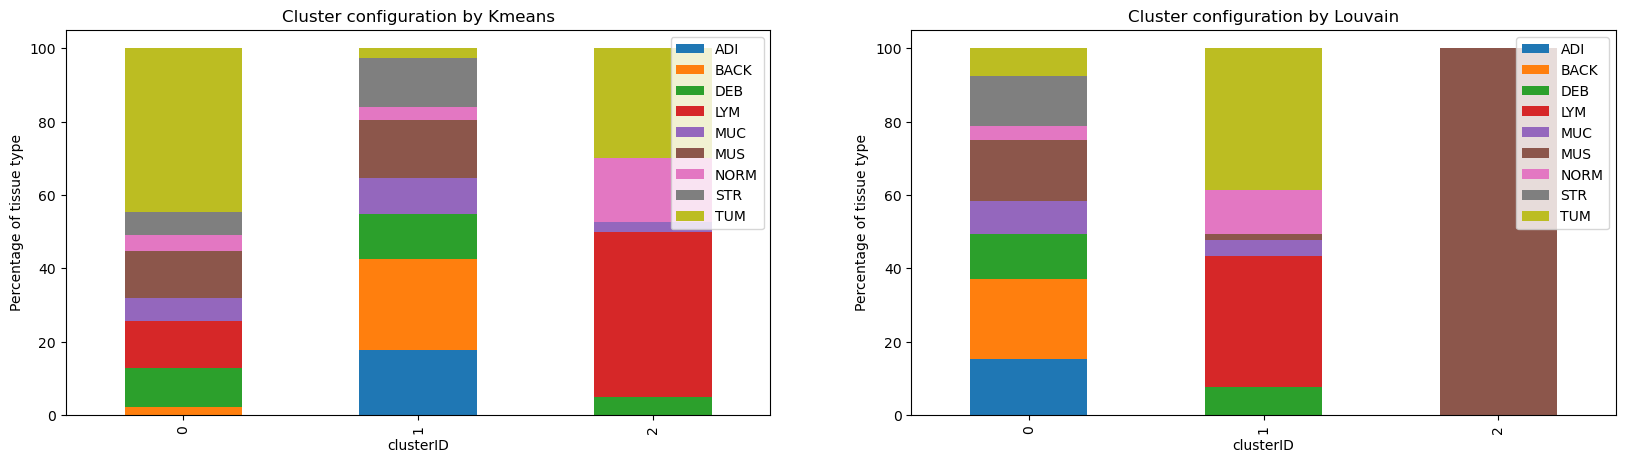

In [27]:
resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


f, axes = plt.subplots(1, 2, figsize=(20,5))
number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

axes[0].set_ylabel('Percentage of tissue type')
axes[0].legend(loc='upper right')
axes[0].set_title('Cluster configuration by Kmeans')

resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': test_label})
label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
df_idx = pivoted_label_proportion_df.index
(pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

axes[1].set_ylabel('Percentage of tissue type')
axes[1].legend(loc='upper right')
axes[1].set_title('Cluster configuration by Louvain')
f.show()